# Distributed haloes analysis
<b>Author</b>: Natalie B. Hogg

**This notebook loads the saved haloes and analyses the image produced**.

Note: for the results shown in the paper, we ran a script on a cluster equivalent to this notebook, due to the slowness of the sampling. The results in the paper are reproduceable with this notebook given sufficent time.

## Contents <a name="contents"></a>
1. [Set up](#setup)
2. [Main lens](#main)
3. [Total haloes](#t)
 1. [Source](#ts)
 2. [Image](#ti)
 3. [MCMC](#tm)
 4. [Contour plot](#tc)
4. [Surviving haloes](#s)
 1. [Source](#ss)
 2. [Image](#si)
 3. [MCMC](#sm)
 4. [Contour plot](#sc)

## Set up <a name="setup"></a>

### Import packages

In [1]:
# computation
import numpy as np
import pandas as pd
from multiprocessing import cpu_count
ncpu = cpu_count()

# plotting
import seaborn as sns
import cmasher as cmr
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams, rcParamsDefault

# cosmology
from colossus.cosmology import cosmology as colcos
from colossus.lss import mass_function
from chainconsumer import ChainConsumer, Chain, PlotConfig, Truth
from astropy.table import Table

# monitoring
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# show figures inline
%matplotlib inline

outpath = r'/home/nataliehogg/Documents/Projects/dist_haloes/proof_of_concept_repo/'

job_name = 'test_for_theo'

# maintain same settings as the population was generated with
theta_E  = 1.5
z_lens   = 0.5 
z_source = 1.5 

### Import `lenstronomy` packages

In [2]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.SimulationAPI.ObservationConfig.HST import HST
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

### Useful functions

In [3]:
def ellipticity(phi, q):
    # transforms orientation angle phi and aspect ratio q into complex ellipticity modulii e1, e2
    e1 = (1 - q)/(1 + q)*np.cos(2*phi)
    e2 = (1 - q)/(1 + q)*np.sin(2*phi)
    return e1, e2

### Global plotting and display settings

In [4]:
# contour plot colours
# thanks to colorbrewer for these palettes! https://colorbrewer2.org
green        = ['#a6dba0','#5aae61','#1b7837']
purple       = ['#c2a5cf', '#9970ab', '#762a83']
analogous    = ['#a0c3db', '#dbb7a0']
warm         = ['#fdcc8a', '#fc8d59', '#d7301f']
cool         = ['#41b6c4', '#2c7fb8', '#253494']

# set the seaborn style
sns.set_style('ticks')

# use TeX for plot labels
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

### Global MCMC settings

In [5]:
sampler      = 'ZEUS'
walker_ratio = 100    # number of walkers per parameter
n_burn       = 10   # number of burn-in steps
n_run        = 10  # number of sampling steps
sigma_scale  = 0.001  # multiplies the initial spread of each parameter

param_sigma  = 0.1 # expected standard deviation of sampled shears
param_min    = -0.5  # lower bound of prior on sampled shears
param_max    = 0.5   # upper bound of prior on sampled shears

## Create main lens: `EPL` <a name="main"></a>

[Back to contents](#contents)

In [6]:
# note the lens position is added later as it needs to be corrected using the alpha_od from the shear data

gamma_epl = 2.6 # slope of power law

# set the ellipticity
lens_orientation_angle = np.random.uniform(0.0, 2*np.pi) # direction of ellipticity relative to the line of sight

# ratio of semi-major axis to semi-minor axis of the ellipse (1 -> circle)
lens_aspect_ratio      = np.random.uniform(0.9, 1.0) # update from 0.8

e1_epl, e2_epl    = ellipticity(lens_orientation_angle, lens_aspect_ratio)

## Load halo and shear data

In [7]:
total_haloes_fits = Table.read(outpath + 'total_haloes_dataframe_' + job_name + '.fits')
total_haloes_dataframe = total_haloes_fits.to_pandas()
total_halo_number = len(total_haloes_dataframe)
total_halo_redshift_list = total_haloes_dataframe['z'].to_list()
kwargs_total_nfw = total_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')
kwargs_total_kappa_neg = [{'kappa': k} for k in total_haloes_dataframe['kappa_neg']]

In [8]:
surviving_haloes_fits = Table.read(outpath + 'surviving_haloes_dataframe_' + job_name + '.fits')
surviving_haloes_dataframe = surviving_haloes_fits.to_pandas()
surviving_halo_number = len(surviving_haloes_dataframe)
surviving_halo_redshift_list = surviving_haloes_dataframe['z'].to_list()
kwargs_surviving_nfw = surviving_haloes_dataframe[['Rs', 'alpha_Rs', 'center_x', 'center_y']].to_dict('records')
kwargs_surviving_kappa_neg = [{'kappa': k} for k in surviving_haloes_dataframe['kappa_neg']]

In [9]:
total_shears_dataframe = pd.read_csv(outpath + 'total_shears_dataframe_' + job_name + '.csv')
surviving_shears_dataframe = pd.read_csv(outpath + 'surviving_shears_dataframe_' + job_name + '.csv')

 ## Total haloes case<a name="t"></a>


 ### Source <a name="ts"></a>
 The source offset correction is different for the two cases, so we have to instantiate two different sources. They have some common parameters though.
 
 [Back to contents](#contents)

In [10]:
source_magnitude = 23.0 # update from 24.0
source_R_sersic = 0.3 # update from 0.03
source_n_sersic = 6.0 # update from 1.0

source_orientation_angle = np.random.uniform(0.0, 2*np.pi) 
source_aspect_ratio      = np.random.uniform(0.9, 1.0) # update from 0.8
source_e1, source_e2 = ellipticity(source_orientation_angle, source_aspect_ratio)

In [11]:
# Sersic, Sersic, burning bright, in the redshifts of the night
# what immortal hand or eye could frame thy fearful symmetry?

total_source_model_list = ['SERSIC_ELLIPSE']

total_kwargs_sersic = {'magnitude': source_magnitude, 
                       'R_sersic': source_R_sersic, 
                       'n_sersic': source_n_sersic,
                       'e1': source_e1, 
                       'e2': source_e2,
                       'center_x': -total_shears_dataframe['alpha1_os'].values[0], 
                       'center_y': -total_shears_dataframe['alpha2_os'].values[0]}

total_kwargs_source = [total_kwargs_sersic]

print('The source model parameters are: {}.'.format(total_kwargs_sersic))

The source model parameters are: {'magnitude': 23.0, 'R_sersic': 0.3, 'n_sersic': 6.0, 'e1': -0.033523468771678555, 'e2': -0.009025811364407567, 'center_x': 9.04361302822558, 'center_y': 4.614767578134189}.


### Image <a name="ti"></a>

[Back to contents](#contents)

In [12]:
total_lens_mock_list = ['EPL'] + ['NFW']*total_halo_number + ['CONVERGENCE']*total_halo_number

total_redshift_list = [z_lens] + 2*total_halo_redshift_list 

total_kwargs_epl = {'theta_E': theta_E,
                    'gamma': gamma_epl,
                    'center_x': -total_shears_dataframe['alpha1_od'].values[0],
                    'center_y': -total_shears_dataframe['alpha2_od'].values[0],
                    'e1': e1_epl,
                    'e2': e2_epl}

total_kwargs_lens = [total_kwargs_epl] + kwargs_total_nfw + kwargs_total_kappa_neg
    
kwargs_model = {'lens_model_list': total_lens_mock_list,
                'lens_redshift_list': total_redshift_list, # the presence of the list tells SimAPI to use multiplane
                'z_source': z_source,
                'source_light_model_list': total_source_model_list}

print('The EPL parameters are: {}.'.format(total_kwargs_epl))

The EPL parameters are: {'theta_E': 1.5, 'gamma': 2.6, 'center_x': -0.2580533657474889, 'center_y': -1.8550557312590108, 'e1': 0.03462562718574911, 'e2': 0.02075286547990695}.


In [13]:
# get the telescope settings for HST
psf = 'GAUSSIAN'
band = HST(band='WFC3_F160W', psf_type=psf) # this chooses the specific camera and filter of HST
kwargs_band = band.kwargs_single_band() # we are only considering a single band (i.e. a single wavelength/filter)
pixel_size = band.camera['pixel_scale'] # in arcsec
kwargs_psf = {'psf_type': psf,
              'fwhm': kwargs_band['seeing'],
              'pixel_size': pixel_size,
              'truncation': 3}

# define the numerics
kwargs_numerics = {'supersampling_factor': 1,
                   'supersampling_convolution': False}

# call the simulation API class
sim = SimAPI(numpix = 64, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_model)

kwargs_data = sim.kwargs_data

In [14]:
# convert magnitudes into amplitudes
# we don't care about lens light or the point source
ll, total_kwargs_source, ps = sim.magnitude2amplitude(kwargs_source_mag = total_kwargs_source)

# now use the SimAPI class to generate a noisy image in one step
imSim = sim.image_model_class(kwargs_numerics)

total_image = imSim.image(kwargs_lens = total_kwargs_lens,
                          kwargs_source = total_kwargs_source)

total_image_noisy = total_image + sim.noise_for_model(model = total_image)

kwargs_data['image_data'] = total_image_noisy

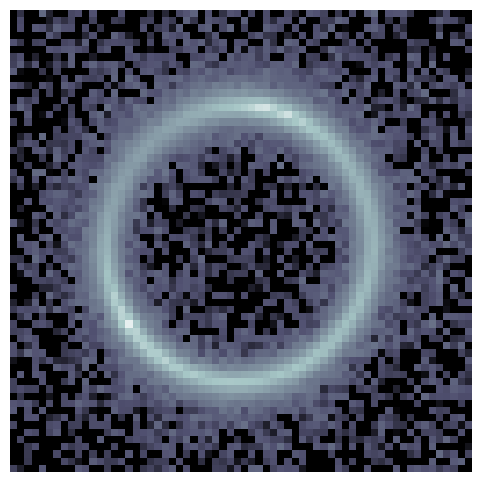

In [15]:
# plot the image
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

total_im = ax.matshow(np.log10(total_image_noisy), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[-1, 1, -1, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.axis('off')

plt.savefig(outpath + job_name + '_total_image.pdf', dpi=300, bbox_inches='tight')

plt.show()

### MCMC <a name="tm"></a>

If you get an error about the MCMC not being able to find the chains file, you need to manually create a `chains` directory inside the directory you specified for `outpath`.

[Back to contents](#contents)

In [16]:
# total haloes lens model

lens_model_list = ['LOS_MINIMAL', 'EPL']

# initialise the lists of parameters
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# Line-of-sight parameters
fixed_lens.append({'kappa_od': total_shears_dataframe['kappa_od'].values[0], 'omega_od': 0.0,
                  'kappa_los': total_shears_dataframe['kappa_los'].values[0]})

# notice the below params need to be defined in this order
# or you will get a key error when trying to run the MCMC

params = ['gamma1_od', 'gamma2_od', 
          'gamma1_los', 'gamma2_los',
          'omega_los']

kwargs_lens_init.append({'gamma1_od': total_shears_dataframe['gamma1_od'].values[0],
                         'gamma2_od': total_shears_dataframe['gamma2_od'].values[0],
                         'gamma1_los': total_shears_dataframe['gamma1_los'].values[0],
                         'gamma2_los': total_shears_dataframe['gamma2_los'].values[0],
                         'omega_los': 0.0})

kwargs_lens_sigma.append({param: param_sigma for param in params})
kwargs_lower_lens.append({param: param_min for param in params})
kwargs_upper_lens.append({param: param_max for param in params})

# EPL
# we are fitting with LOS so we expect the image to be centred on ZERO!!!
# i.e. source corrections are naturally present in an LOS model!
fixed_lens.append({})

kwargs_lens_init.append({'theta_E': total_kwargs_epl['theta_E'], 
                         'gamma': total_kwargs_epl['gamma'], 
                         'center_x': 0.0, 
                         'center_y': 0.0,
                         'e1': total_kwargs_epl['e1'], 
                         'e2': total_kwargs_epl['e2']})

kwargs_lens_sigma.append({'theta_E': 0.1, 'gamma': 0.1, 
                          'center_x': 0.1, 'center_y': 0.1, 
                          'e1': 0.1, 'e2': 0.1})

kwargs_lower_lens.append({'theta_E': 0.1, 'gamma': 1.0, 
                          'center_x': -10.0, 'center_y': -10.0, 
                          'e1': -1.0, 'e2': -1.0})

kwargs_upper_lens.append({'theta_E': 5.0, 'gamma': 3.0, 
                          'center_x': 10.0, 'center_y': 10.0,
                          'e1': 1.0, 'e2': 1.0})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# source

source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

kwargs_source_init.append({'R_sersic': total_kwargs_sersic['R_sersic'], 
                           'n_sersic': total_kwargs_sersic['n_sersic'], 
                           'center_x': 0.0, 
                           'center_y': 0.0,
                           'e1': total_kwargs_sersic['e1'], 
                           'e2': total_kwargs_sersic['e2']})

kwargs_source_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.1, 
                          'center_x': 0.1, 'center_y': 0.1,
                          'e1': 0.1, 'e2': 0.1})

kwargs_lower_source.append({'R_sersic': 0.0, 'n_sersic': 1.0, 
                          'center_x': -10.0, 'center_y': -10.0,
                          'e1': -1.0, 'e2': -1.0})

kwargs_upper_source.append({'R_sersic': 5.0, 'n_sersic': 10.0,
                          'center_x': 10.0, 'center_y': 10.0,
                          'e1': 1.0, 'e2': 1.0})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params}

In [17]:
# run the MCMC
kwargs_likelihood = {'source_marg': True}

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {'multi_band_list': multi_band_list,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params)

# when running with zeus we use different settings
fitting_kwargs_list = [['zeus',
                        {'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio, 
                         #'threadCount': ncpu,
                         'mu': 1e3,
                         'tune': True,
                         'sigma_scale': sigma_scale,
                         'backend_filename': outpath + 'chains/' 
                         + job_name + '_total_'+sampler+'.h5'}]]


chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

print('Best-fit parameters: {}'.format(kwargs_result))

Initialising ensemble of 1700 walkers...


Using zeus to perform the MCMC.


Sampling progress : 100%|████████████████████████████████████████████████████████████████████████████████████| 20/20 [07:30<00:00, 22.55s/it]

Best-fit parameters: {'kwargs_lens': [{'kappa_od': -0.055354176797806, 'gamma1_od': -0.03972832243410589, 'gamma2_od': -0.009481164716706415, 'omega_od': 0.0, 'kappa_los': -0.058816695958086, 'gamma1_los': -0.044469082378049314, 'gamma2_los': 0.016827824006101538, 'omega_los': -0.0040764324290090215}, {'theta_E': 1.5397359768853898, 'gamma': 2.6718804010431954, 'e1': 0.05755203927848382, 'e2': 0.07105423508505411, 'center_x': 0.004446196824911925, 'center_y': 0.01308112460356451}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.3000949174949834, 'n_sersic': 5.987828685361584, 'e1': -0.028724447659312775, 'e2': -0.04617302107867945, 'center_x': -0.040328380043434885, 'center_y': -0.05562246157041572}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


In [18]:
print('\nThe predicted LOS terms were:')
print('gamma1_od  = {:.4}'.format(total_shears_dataframe['gamma1_od'].values[0]))
print('gamma2_od  = {:.4}'.format(total_shears_dataframe['gamma2_od'].values[0]))
print('gamma1_los = {:.4}'.format(total_shears_dataframe['gamma1_los'].values[0]))
print('gamma2_los = {:.4}'.format(total_shears_dataframe['gamma2_los'].values[0]))
print('omega_los  = {:.4}'.format(0.0))


print('\nThe fit LOS terms are:')
for i in params:
    print(str(i)+' = {:.4}'.format(kwargs_result['kwargs_lens'][0][i]))


The predicted LOS terms were:
gamma1_od  = -0.003283
gamma2_od  = 0.005996
gamma1_los = -0.01728
gamma2_los = 0.01275
omega_los  = 0.0

The fit LOS terms are:
gamma1_od = -0.03973
gamma2_od = -0.009481
gamma1_los = -0.04447
gamma2_los = 0.01683
omega_los = -0.004076


-15.020839642391682 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  15.020839642391682


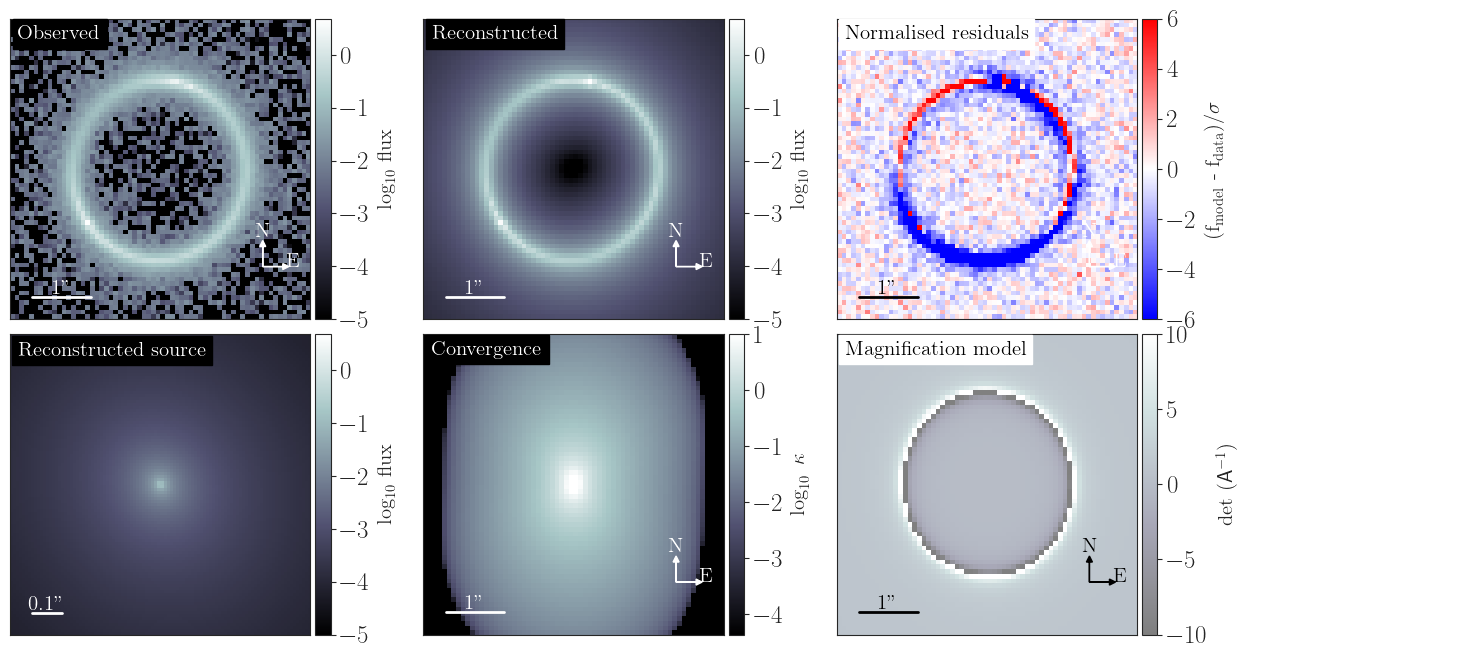

In [19]:
# look at the reconstructed image
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string='bone')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], text="Normalised residuals")
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath + job_name + '_total_reconstruction.pdf', dpi=300, bbox_inches='tight')

plt.show()

-15.020839642391682 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  15.020839642391682


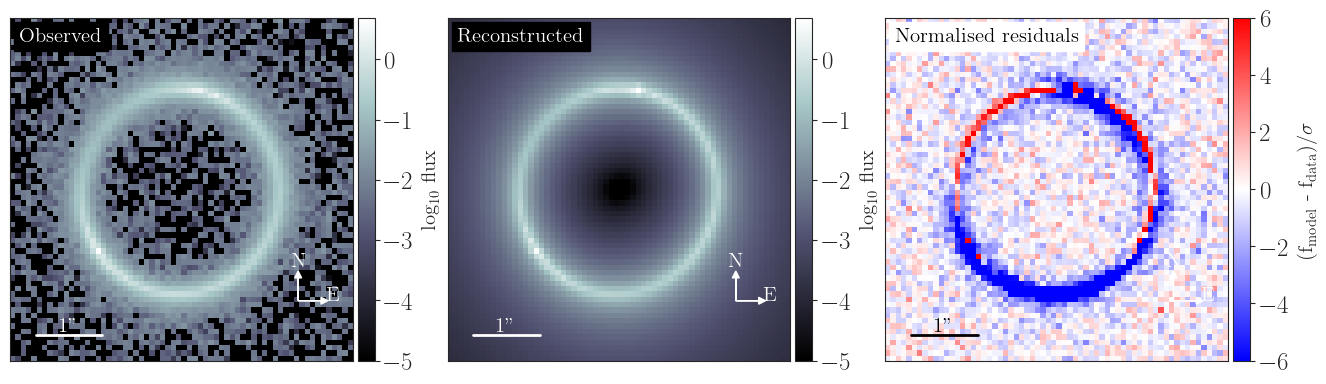

In [20]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string='bone')
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0])
modelPlot.model_plot(ax=axes[1])
modelPlot.normalized_residual_plot(ax=axes[2], text="Normalised residuals")

plt.savefig(outpath + job_name + '_total_reconstruction_top.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
# convergence check
rcParams.update(rcParamsDefault) # reset default font because this plot looks weird otherwise

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc_total, param_mcmc, dist_mcmc  = chain_list[0]

print('Number of non-linear parameters in the MCMC process: {}'.format(len(param_mcmc)))
print('Parameters in order: {}'.format(param_mcmc))
print('Number of evaluations in the MCMC process: {}'.format(np.shape(samples_mcmc_total)[0]))

Number of non-linear parameters in the MCMC process: 17
Parameters in order: ['gamma1_od_lens0', 'gamma2_od_lens0', 'gamma1_los_lens0', 'gamma2_los_lens0', 'omega_los_lens0', 'theta_E_lens1', 'gamma_lens1', 'e1_lens1', 'e2_lens1', 'center_x_lens1', 'center_y_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
Number of evaluations in the MCMC process: 17000


In [22]:
# "if you have a procedure with ten parameters, you probably missed some"

labels = [# LOS
          r'$\gamma^{\rm od}_1$',
          r'$\gamma^{\rm od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega^{\rm LOS}$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$x$',
          r'$y$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sérsic}$',
          r'$n_{\rm Sérsic}$',
          r'$x$',
          r'$y$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$']

expected_values = [# LOS
                   total_shears_dataframe['gamma1_od'].values[0],
                   total_shears_dataframe['gamma2_od'].values[0],
                   total_shears_dataframe['gamma1_los'].values[0],
                   total_shears_dataframe['gamma2_los'].values[0],
                   0.0,
                   # EPL
                   total_kwargs_epl['theta_E'],
                   total_kwargs_epl['gamma'],
                   0.0,
                   0.0,
                   total_kwargs_epl['e1'],
                   total_kwargs_epl['e2'],
                   # source
                   total_kwargs_sersic['R_sersic'],
                   total_kwargs_sersic['n_sersic'],
                   0.0,
                   0.0,
                   total_kwargs_sersic['e1'],
                   total_kwargs_sersic['e2']]

n, num_param = np.shape(samples_mcmc_total)

### Contour plot <a name="tc"> </a>
 
 [Back to contents](#contents)

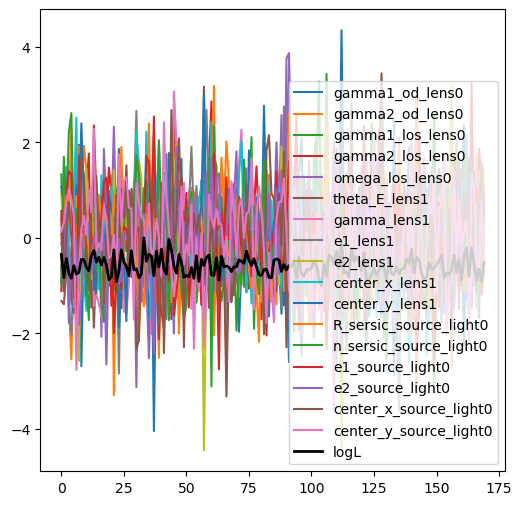

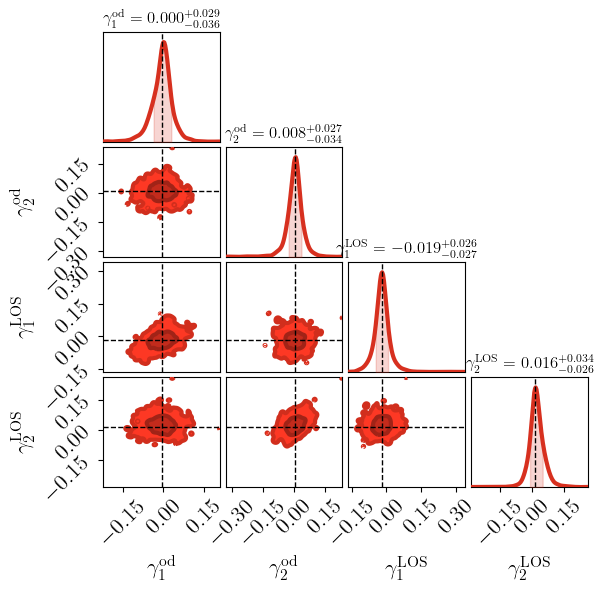

In [23]:
c = ChainConsumer()

df = pd.DataFrame.from_dict({par: val for par, val in zip(labels, samples_mcmc_total.T)})

shears_df = df.loc[:,[r'$\gamma^{\rm od}_1$',r'$\gamma^{\rm od}_2$',
                      r'$\gamma^{\rm LOS}_1$',r'$\gamma^{\rm LOS}_2$']]

c.add_chain(Chain(samples=shears_df, name='zeus',
                  shade=True, color=warm[2],
                  shade_gradient = 0.4, linewidth=3.0))

c.set_plot_config(PlotConfig(max_ticks = 4, flip=False,
                             serif=True, usetex=True,
                             label_font_size=16, tick_font_size=16,
                             spacing=1.0, summarise=True,
                             legend_color_text=False))

c.add_truth(Truth(location={r'$\gamma^{\rm od}_1$': expected_values[0], 
                            r'$\gamma^{\rm od}_2$': expected_values[1],
                            r'$\gamma^{\rm LOS}_1$': expected_values[2], 
                            r'$\gamma^{\rm LOS}_2$': expected_values[3],}))

fig = c.plotter.plot(figsize=(6,6))
plt.show()

In [ ]:
# n_walkers = len(param_mcmc)*walker_ratio

# c = ChainConsumer()

# fontsize = 16

# c.add_chain(samples_mcmc_total[:,0:4], walkers = n_walkers, parameters = labels[0:4])

# c.configure(flip = False, summary = False, 
#             spacing = 3.0, max_ticks = 4,
#             colors = warm[2], shade = True, shade_gradient = 0.4, 
#             bar_shade = True, linewidths= [3.0],
#             tick_font_size=fontsize, label_font_size=fontsize, 
#             usetex = True, serif = True,
#             contour_labels = 'sigma', contour_label_font_size = fontsize)

# fig = c.plotter.plot(truth=expected_values[0:4], figsize = (8,8))

# fig.patch.set_facecolor('white')

# plt.savefig(outpath + job_name + '_total_contours.pdf', dpi=300, bbox_inches='tight')

# gelman_rubin_converged = c.diagnostic.gelman_rubin() # not clear if this is robust for emcee or zeus chains

# print(gelman_rubin_converged)

In [ ]:
# n_walkers = len(param_mcmc)*walker_ratio

# c = ChainConsumer()

# fontsize = 16

# c.add_chain(samples_mcmc_total[:,2:4], walkers = n_walkers, parameters = labels[2:4])

# c.configure(flip = False, summary = False, 
#             spacing = 3.0, max_ticks = 4,
#             colors = warm[2], shade = True, shade_gradient = 0.4, 
#             bar_shade = True, linewidths= [3.0],
#             tick_font_size=fontsize, label_font_size=fontsize, 
#             usetex = True, serif = True,
#             contour_labels = 'sigma', contour_label_font_size = fontsize)

# fig = c.plotter.plot(truth=expected_values[2:4], figsize = (5,5))

# fig.patch.set_facecolor('white')

# plt.savefig(outpath + job_name + '_total_contours_LOS.pdf', dpi=300, bbox_inches='tight')

# gelman_rubin_converged = c.diagnostic.gelman_rubin()

# print(gelman_rubin_converged)

## Surviving haloes<a name="s"> </a>

### Source <a name = "ss"> </a>

 [Back to contents](#contents)

In [ ]:
surviving_source_model_list = ['SERSIC_ELLIPSE']

surviving_kwargs_sersic = {'magnitude': source_magnitude, 
                           'R_sersic': source_R_sersic, 
                           'n_sersic': source_n_sersic,
                           'e1': source_e1, 
                           'e2': source_e2,
                           'center_x': -surviving_shears_dataframe['alpha1_os'].values[0], 
                           'center_y': -surviving_shears_dataframe['alpha2_os'].values[0]}

surviving_kwargs_source = [surviving_kwargs_sersic]

In [ ]:
surviving_lens_mock_list = ['EPL'] + ['NFW']*surviving_halo_number + ['CONVERGENCE']*surviving_halo_number

surviving_redshift_list = [z_lens] + 2*surviving_halo_redshift_list 

surviving_kwargs_epl = {'theta_E': theta_E,
                    'gamma': gamma_epl,
                    'center_x': -surviving_shears_dataframe['alpha1_od'].values[0],
                    'center_y': -surviving_shears_dataframe['alpha2_od'].values[0],
                    'e1': e1_epl,
                    'e2': e2_epl}

surviving_kwargs_lens = [surviving_kwargs_epl] + kwargs_surviving_nfw + kwargs_surviving_kappa_neg

    
        
kwargs_surviving_model = {'lens_model_list': surviving_lens_mock_list,
                          'lens_redshift_list': surviving_redshift_list,
                          'z_source': z_source,
                          'source_light_model_list': surviving_source_model_list}

### Image<a name = "si"> </a>

 [Back to contents](#contents)

In [ ]:
# call the simulation API class
sim_sur = SimAPI(numpix = 64, # number of pixels we want in our image
             kwargs_single_band = kwargs_band, # give the SimAPI class the keyword arguments for HST that we got above
             kwargs_model = kwargs_surviving_model)

kwargs_data_sur = sim_sur.kwargs_data

ll, surviving_kwargs_source, ps = sim_sur.magnitude2amplitude(kwargs_source_mag=surviving_kwargs_source)

imSim_sur = sim_sur.image_model_class(kwargs_numerics)

surviving_image = imSim_sur.image(kwargs_lens = surviving_kwargs_lens,
                              kwargs_source = surviving_kwargs_source)

surviving_image_noisy = surviving_image + sim_sur.noise_for_model(model=surviving_image)

kwargs_data_sur['image_data'] = surviving_image_noisy

In [ ]:
cmap_string = 'bone'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

fig, ax = plt.subplots(1, 1, figsize=(6,6))

total_im = ax.matshow(np.log10(surviving_image_noisy), origin='lower', 
                      vmin=v_min, vmax=v_max, cmap=cmap, extent=[-1, 1, -1, 1])

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
ax.axis('off')

plt.savefig(outpath + job_name + '_surviving_image.pdf', dpi=300, bbox_inches='tight')

plt.show()

### MCMC<a name = "sm"> </a>

 [Back to contents](#contents)

In [ ]:
# surviving haloes lens model

lens_model_list = ['LOS_MINIMAL', 'EPL']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

# LOS
fixed_lens.append({'kappa_od': surviving_shears_dataframe['kappa_od'].values[0],'omega_od': 0.0,
                  'kappa_los': surviving_shears_dataframe['kappa_los'].values[0]})

params = ['gamma1_od', 'gamma2_od', 
          'gamma1_los', 'gamma2_los',
          'omega_los']

kwargs_lens_init.append({'gamma1_od': surviving_shears_dataframe['gamma1_od'].values[0],
                         'gamma2_od': surviving_shears_dataframe['gamma2_od'].values[0],
                         'gamma1_los': surviving_shears_dataframe['gamma1_los'].values[0],
                         'gamma2_los': surviving_shears_dataframe['gamma2_los'].values[0],
                         'omega_los': 0.0})

kwargs_lens_sigma.append({param: param_sigma for param in params})
kwargs_lower_lens.append({param: param_min for param in params})
kwargs_upper_lens.append({param: param_max for param in params})

# EPL
fixed_lens.append({})

kwargs_lens_init.append({'theta_E': surviving_kwargs_epl['theta_E'], 
                         'gamma': surviving_kwargs_epl['gamma'], 
                         'center_x': 0.0, 
                         'center_y': 0.0,
                         'e1': surviving_kwargs_epl['e1'], 
                         'e2': surviving_kwargs_epl['e2']})

kwargs_lens_sigma.append({'theta_E': 0.1, 'gamma': 0.1, 
                          'center_x': 0.1, 'center_y': 0.1, 
                          'e1': 0.1, 'e2': 0.1})

kwargs_lower_lens.append({'theta_E': 0.1, 'gamma': 1.0, 
                          'center_x': -1.0, 'center_y': -1.0, 
                          'e1': -1.0, 'e2': -1.0})

kwargs_upper_lens.append({'theta_E': 5.0, 'gamma': 3.0, 
                          'center_x': 1.0, 'center_y': 1.0,
                          'e1': 1.0, 'e2': 1.0})

lens_params = [kwargs_lens_init,
               kwargs_lens_sigma,
               fixed_lens,
               kwargs_lower_lens,
               kwargs_upper_lens]

# source

source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})

kwargs_source_init.append({'R_sersic': surviving_kwargs_sersic['R_sersic'], 
                           'n_sersic': surviving_kwargs_sersic['n_sersic'], 
                           'center_x': 0.0, 
                           'center_y': 0.0,
                           'e1': surviving_kwargs_sersic['e1'], 
                           'e2': surviving_kwargs_sersic['e2']})

kwargs_source_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.1, 
                          'center_x': 0.1, 'center_y': 0.1,
                          'e1': 0.1, 'e2': 0.1})

kwargs_lower_source.append({'R_sersic': 0.0, 'n_sersic': 1.0, 
                          'center_x': -1.0, 'center_y': -1.0,
                          'e1': -1.0, 'e2': -1.0})

kwargs_upper_source.append({'R_sersic': 5.0, 'n_sersic': 10.0,
                          'center_x': 1.0, 'center_y': 1.0,
                          'e1': 1.0, 'e2': 1.0})

source_params = [kwargs_source_init, kwargs_source_sigma,
                 fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params_sur = {'lens_model': lens_params,
                 'source_model': source_params}

In [ ]:
# run the MCMC
kwargs_likelihood = {'source_marg': True}

kwargs_model_sur = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_model_list}

multi_band_list_sur = [[kwargs_data_sur, kwargs_psf, kwargs_numerics]]

kwargs_data_joint_sur = {'multi_band_list': multi_band_list_sur,
                     'multi_band_type': 'multi-linear'}

kwargs_constraints = {}

fitting_seq_sur = FittingSequence(kwargs_data_joint_sur, kwargs_model_sur, kwargs_constraints, 
                              kwargs_likelihood, kwargs_params_sur)

fitting_kwargs_list = [['zeus',
                        {#'sampler_type': sampler,
                         'n_burn': n_burn, 
                         'n_run': n_run,
                         'walkerRatio': walker_ratio, 
                         #'threadCount': ncpu,
                          'mu': 1e3,
                         'tune': True,
                         'sigma_scale': sigma_scale,
                         'backend_filename': outpath + 'chains/' 
                         + job_name + '_surviving_'+sampler+'.h5'}]]

chain_list_sur = fitting_seq_sur.fit_sequence(fitting_kwargs_list)
kwargs_result_sur = fitting_seq_sur.best_fit()

print('Best fit parameters: {}'.format(kwargs_result_sur))

In [ ]:
print('\nThe predicted LOS terms were:')
print('gamma1_od  = {:.4}'.format(surviving_shears_dataframe['gamma1_od'].values[0]))
print('gamma2_od  = {:.4}'.format(surviving_shears_dataframe['gamma2_od'].values[0]))
print('gamma1_los = {:.4}'.format(surviving_shears_dataframe['gamma1_los'].values[0]))
print('gamma2_los = {:.4}'.format(surviving_shears_dataframe['gamma2_los'].values[0]))
print('omega_los  = {:.4}'.format(0.0))


print('\nThe fit LOS terms are:')
for i in params:
    print(str(i)+' = {:.4}'.format(kwargs_result_sur['kwargs_lens'][0][i]))

In [ ]:
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

modelPlot_sur = ModelPlot(multi_band_list_sur, kwargs_model_sur, 
                          kwargs_result_sur, arrow_size=0.02, cmap_string='bone')
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot_sur.data_plot(ax=axes[0,0])
modelPlot_sur.model_plot(ax=axes[0,1])
modelPlot_sur.normalized_residual_plot(ax=axes[0,2], text='Normalised residuals',v_min=-6, v_max=6)
modelPlot_sur.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot_sur.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot_sur.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)

plt.savefig(outpath+ job_name + '_surviving_reconstruction.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot_sur.data_plot(ax=axes[0])
modelPlot_sur.model_plot(ax=axes[1])
modelPlot_sur.normalized_residual_plot(ax=axes[2], text="Normalised residuals")
f.tight_layout()

plt.savefig(outpath + job_name + '_surviving_reconstruction_top.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
rcParams.update(rcParamsDefault) 

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list_sur, i)
    
sampler_type, samples_mcmc_sur, param_mcmc_sur, dist_mcmc  = chain_list_sur[0]

print('Number of non-linear parameters in the MCMC process: {}'.format(len(param_mcmc_sur)))
print('Parameters in order: {}'.format(param_mcmc_sur))
print('Number of evaluations in the MCMC process: {}'.format(np.shape(samples_mcmc_sur)[0]))

In [ ]:
labels_sur = [# LOS
          r'$\gamma^{\rm od}_1$',
          r'$\gamma^{\rm od}_2$',
          r'$\gamma^{\rm LOS}_1$',
          r'$\gamma^{\rm LOS}_2$',
          r'$\omega^{\rm LOS}$',
          # EPL
          r'$\theta_{\rm E}$',
          r'$\gamma_{\rm EPL}$',
          r'$x$',
          r'$y$',
          r'$e_{1, \rm EPL}$',
          r'$e_{2, \rm EPL}$',
          # source
          r'$R_{\rm Sersic}$',
          r'$n_{\rm Sersic}$',
          r'$x$',
          r'$y$',
          r'$e_1^{\rm source}$',
          r'$e_2^{\rm source}$']

expected_values_sur = [# LOS
                   surviving_shears_dataframe['gamma1_od'].values[0],
                   surviving_shears_dataframe['gamma2_od'].values[0],
                   surviving_shears_dataframe['gamma1_los'].values[0],
                   surviving_shears_dataframe['gamma2_los'].values[0],
                   0.0,
                   # EPL
                   surviving_kwargs_epl['theta_E'],
                   surviving_kwargs_epl['gamma'],
                   0.0,
                   0.0,
                   surviving_kwargs_epl['e1'],
                   surviving_kwargs_epl['e2'],
                   # source
                   surviving_kwargs_sersic['R_sersic'],
                   surviving_kwargs_sersic['n_sersic'],
                   0.0,
                   0.0,
                   surviving_kwargs_sersic['e1'],
                   surviving_kwargs_sersic['e2']]

n, num_param = np.shape(samples_mcmc_sur)

### Contour plot <a name = "sc"> </a>

 [Back to contents](#contents)

In [ ]:
c = ChainConsumer()

df_sur = pd.DataFrame.from_dict({par: val for par, val in zip(labels, samples_mcmc_sur.T)})

shears_df_sur = df_sur.loc[:,[r'$\gamma^{\rm od}_1$',r'$\gamma^{\rm od}_2$',
                              r'$\gamma^{\rm LOS}_1$',r'$\gamma^{\rm LOS}_2$']]

c.add_chain(Chain(samples=shears_df_sur, name='zeus',
                  shade=True, color=cool[2],
                  shade_gradient = 0.4, linewidth=3.0))

c.set_plot_config(PlotConfig(max_ticks = 4, flip=False,
                             serif=True, usetex=True,
                             label_font_size=16, tick_font_size=16,
                             spacing=1.0, summarise=True,
                             legend_color_text=False))

c.add_truth(Truth(location={r'$\gamma^{\rm od}_1$': expected_values_sur[0], 
                            r'$\gamma^{\rm od}_2$': expected_values_sur[1],
                            r'$\gamma^{\rm LOS}_1$': expected_values_sur[2], 
                            r'$\gamma^{\rm LOS}_2$': expected_values_sur[3],}))

fig = c.plotter.plot(figsize=(6,6))
plt.show()

In [ ]:
# n_walkers = len(param_mcmc_sur)*walker_ratio

# c = ChainConsumer()

# fontsize=16

# c.add_chain(samples_mcmc_sur[:,0:4], walkers = n_walkers, parameters = labels_sur[0:4])

# c.configure(flip = False, summary = False, 
#             spacing = 3.0, max_ticks = 4,
#             colors = cool[2], shade = True, shade_gradient = 0.4, 
#             bar_shade = True, linewidths= [3.0],
#             tick_font_size=fontsize, label_font_size=fontsize, 
#             usetex = True, serif = True,
#             contour_labels = 'sigma', contour_label_font_size = fontsize)

# fig = c.plotter.plot(truth=expected_values_sur[0:4], figsize = (8,8))

# fig.patch.set_facecolor('white')

# plt.savefig(outpath + job_name + '_surviving_contours.pdf', dpi=300, bbox_inches='tight')

# gelman_rubin_converged = c.diagnostic.gelman_rubin()

# print(gelman_rubin_converged)

In [ ]:
# n_walkers = len(param_mcmc_sur)*walker_ratio

# c = ChainConsumer()

# fontsize=16

# c.add_chain(samples_mcmc_sur[:,2:4], walkers = n_walkers, parameters = labels_sur[2:4])

# c.configure(flip = False, summary = False, 
#             spacing = 3.0, max_ticks = 4,
#             colors = cool[2], shade = True, shade_gradient = 0.4, 
#             bar_shade = True, linewidths= [3.0],
#             tick_font_size=fontsize, label_font_size=fontsize, 
#             usetex = True, serif = True,
#             contour_labels = 'sigma', contour_label_font_size = fontsize)

# fig = c.plotter.plot(truth=expected_values_sur[2:4], figsize = (5,5))

# fig.patch.set_facecolor('white')

# plt.savefig(outpath + job_name + '_surviving_contours_LOS.pdf', dpi=300, bbox_inches='tight')

# gelman_rubin_converged = c.diagnostic.gelman_rubin()

# print(gelman_rubin_converged)

[Back to contents](#contents)